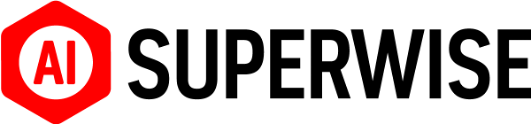

# **Example:  Interacting with a MCP Server**

This example shows how a Superwise Agent can interact with an MCP Server.  In this particular case we are using an API that returns the exact distance to the moon from locations on earth on the current date from here:  https://ipgeolocation.io/.  We are then wrapping that API into an MCP Server.  Then we are calling that MCP server from the result of a query to a Superwise agent.

#**Create the MCP Server**

**Access the IP Geolocation API**

In [1]:
import requests
import json

In [2]:
#ipgeolocationAPI = "YourAPI_Key_From_the_Above_link"
ipgeolocationAPI = "<Your API Key>"

In [3]:
astronomy_url = "https://api.ipgeolocation.io/astronomy"

In [4]:
async def send_moon_distance_request(url, method="GET", headers=None, data=None, json=None, params=None):
    try:
        response = requests.request(method, url, headers=headers, data=data, json=json, params=params)
        response.raise_for_status() # Raise an exception for bad status codes
        return response
    except requests.exceptions.RequestException as e:
        print(f"Error sending request: {e}")
        return None

**Test the API Connection**

In [5]:
test_answer = await send_moon_distance_request(astronomy_url, params={"apiKey": ipgeolocationAPI, "location": "Charleston"})

In [6]:
data = json.loads(test_answer.text)
city = data.get("location").get("location")
state = data.get("location").get("state")
date = data.get("date")
moon_distance = data.get("moon_distance")
print(f"City: {city}")
print(f"State: {state}")
print(f"Date: {date}")
print(f"Moon Distance: {moon_distance}")

City: Charleston
State: South Carolina
Date: 2025-03-16
Moon Distance: 405428.9966667338


**Create the MCP Server that accesses the API**

In [7]:
# Note the is a dependency resolver error in Colab when installing MCP.
# For the purposes of this demo you can ignore that error
!pip install mcp --quiet

In [8]:
from mcp import Tool
from mcp.server import Server
import mcp.types as types

In [9]:
app_practice = Server("mcp-practice-server")

In [10]:
@app_practice.call_tool()
async def call_tool(
  name: str, arguments: dict
) -> list[types.TextContent | types.ImageContent | types.EmbeddedResource]:
    if name == "moon_distance":
      return await send_moon_distance_request(astronomy_url, params=arguments)
    else:
        raise ValueError(f"Unknown tool '{name}'")

**Test the MCP Server Connection to the API**

In [11]:
# Pass the tool name and inputs as a dictionary within a single dictionary
mcp_answer = await call_tool("moon_distance", {"apiKey": ipgeolocationAPI, "location": "New York"})

In [12]:
data = json.loads(mcp_answer.text)
city = data.get("location").get("location")
state = data.get("location").get("state")
date = data.get("date")
moon_distance = data.get("moon_distance")
print(f"City: {city}")
print(f"State: {state}")
print(f"Date: {date}")
print(f"Moon Distance: {moon_distance}")

City: New York
State: New York
Date: 2025-03-16
Moon Distance: 405429.2129388752


#**Create the Superwise Agent that with the MCP Server**

Note this is a small subset of all you can do with Superwise.  
For complete Superwise capabilities visit: https://docs-swe.superwise.ai/

In [13]:
!pip install superwise-api --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 5.2 MB/s eta 0:00:00


In [14]:
import os
from superwise_api.superwise_client import SuperwiseClient

os.environ['SUPERWISE_CLIENT_ID'] = '<Your Superwise Client ID>'
os.environ['SUPERWISE_CLIENT_SECRET'] = '<Your Superwise Client Secret'

sw = SuperwiseClient()

In [15]:
#Create your agent to receive an application request for moon distance
from superwise_api.models.application.application import AdvancedAgentConfig

app = sw.application.create(
    name="Moon_Distance_From_Location_On_Earth",
    additional_config=AdvancedAgentConfig(tools=[]),
    llm_model=None
)

In [16]:
#Add your choice of LLM to the Agent
from superwise_api.models.application.application import OpenAIModel, OpenAIModelVersion
from superwise_api.models.application.application import AdvancedAgentConfig

llm_model = OpenAIModel(version=OpenAIModelVersion.GPT_4, api_token="<Your OpenAI API Key>")
app = sw.application.put(str(app.id),
                         additional_config=AdvancedAgentConfig(tools=[]),
                         llm_model=llm_model,
                         prompt=None,
                         name="Moon_Distance_From_Location_On_Earth"
                        )

In [17]:
#test the connection to the agent
try:
    sw.application.test_model_connection(model)
except Exception as e:
    print("Model test connection failed!")

print("Model test connection success!")

Model test connection failed!
Model test connection success!


In [18]:
#test the agent
swe_answer = sw.application.ask_playground(
  input="What is the capital of France?",
  llm_model=llm_model,
  prompt="Just another promp",
  chat_history=[],
  additional_config=AdvancedAgentConfig(tools=[]) # Pass an AdvancedAgentConfig object
)
print(swe_answer)

output='The capital of France is Paris.' metadata=ResponseMetadata(cite_sources=None, debug_metadata=DebugMetadata(question='What is the capital of France?', answer='The capital of France is Paris.', start_time=datetime.datetime(2025, 3, 16, 20, 46, 27, 615402, tzinfo=TzInfo(UTC)), end_time=datetime.datetime(2025, 3, 16, 20, 46, 29, 352148, tzinfo=TzInfo(UTC)), intermediate_steps=[IntermediateStep(start_time=datetime.datetime(2025, 3, 16, 20, 46, 27, 623865), end_time=datetime.datetime(2025, 3, 16, 20, 46, 29, 350655), input_data='Human: You are an Assistant, respond to the human as helpfully and accurately as possible.\n\nTOOLS:\n------\n\nAssistant has access to the following tools, but it might also get zero tools in some cases, in which case you should just respond to the Human.\n\nHere are the tools that Assistant has access to, if this is empty, then Assistant has no tools to use:\n\n\n\nTo use a tool, please use the following format:\n\n```\nThought: Do I need to use a tool? Yes

In [19]:
#add a prompt to direct the output to be only what is needed for the MCP server
mcp_prompt = "You are an expert in locations, return only the location that the requestor is at. Just state the location without any other text or punctuation"

In [21]:
#test the agent with the updated prompt
swe_answer = sw.application.ask_playground(
  input="I am in Paris now, How Far is the Moon from me?",
  llm_model=llm_model,
  prompt=mcp_prompt,
  chat_history=[],
  additional_config=AdvancedAgentConfig(tools=[]) # Pass an AdvancedAgentConfig object
)
print(swe_answer)

output='Paris' metadata=ResponseMetadata(cite_sources=None, debug_metadata=DebugMetadata(question='I am in Paris now, How Far is the Moon from me?', answer='Paris', start_time=datetime.datetime(2025, 3, 16, 20, 46, 48, 756532, tzinfo=TzInfo(UTC)), end_time=datetime.datetime(2025, 3, 16, 20, 46, 50, 56430, tzinfo=TzInfo(UTC)), intermediate_steps=[IntermediateStep(start_time=datetime.datetime(2025, 3, 16, 20, 46, 48, 769648), end_time=datetime.datetime(2025, 3, 16, 20, 46, 50, 53978), input_data='Human: You are an Assistant, respond to the human as helpfully and accurately as possible.\n\nTOOLS:\n------\n\nAssistant has access to the following tools, but it might also get zero tools in some cases, in which case you should just respond to the Human.\n\nHere are the tools that Assistant has access to, if this is empty, then Assistant has no tools to use:\n\n\n\nTo use a tool, please use the following format:\n\n```\nThought: Do I need to use a tool? Yes\nAction: the action to take, should 

#**Flow the output of Superwise Agent to the input of the MCP Server**

In [22]:
swe_answer = sw.application.ask_playground(
  input="How far is the moon from Nashville?",
  llm_model=llm_model,
  prompt="You are an expert in locations, return only the location that the requestor is at. Just state the location without any other text or punctuation",
  chat_history=[],
  additional_config=AdvancedAgentConfig(tools=[]) # Pass an AdvancedAgentConfig object
)
print(swe_answer)

output='Nashville' metadata=ResponseMetadata(cite_sources=None, debug_metadata=DebugMetadata(question='How far is the moon from Nashville?', answer='Nashville', start_time=datetime.datetime(2025, 3, 16, 20, 47, 25, 48945, tzinfo=TzInfo(UTC)), end_time=datetime.datetime(2025, 3, 16, 20, 47, 26, 38405, tzinfo=TzInfo(UTC)), intermediate_steps=[IntermediateStep(start_time=datetime.datetime(2025, 3, 16, 20, 47, 25, 56961), end_time=datetime.datetime(2025, 3, 16, 20, 47, 26, 36594), input_data='Human: You are an Assistant, respond to the human as helpfully and accurately as possible.\n\nTOOLS:\n------\n\nAssistant has access to the following tools, but it might also get zero tools in some cases, in which case you should just respond to the Human.\n\nHere are the tools that Assistant has access to, if this is empty, then Assistant has no tools to use:\n\n\n\nTo use a tool, please use the following format:\n\n```\nThought: Do I need to use a tool? Yes\nAction: the action to take, should be one

In [23]:
input_to_mcp_server = swe_answer.output

In [24]:
input_to_mcp_server

'Nashville'

In [25]:
answer = await call_tool("moon_distance", {"apiKey": ipgeolocationAPI, "location": input_to_mcp_server})

**Retrieve the answer**

In [26]:
data = json.loads(answer.text)
city = data.get("location").get("location")
state = data.get("location").get("state")
date = data.get("date")
moon_distance = data.get("moon_distance")
print(f"City: {city}")
print(f"State: {state}")
print(f"Date: {date}")
print(f"Moon Distance: {moon_distance}")

City: Nashville
State: Tennessee
Date: 2025-03-16
Moon Distance: 405430.8306380691


# **This is just a basic example.  For a real application you would use Superwise Guardrails (https://docs-swe.superwise.ai/docs/guardrails-1) capabilities to make sure application input is only about moon distance requests from a place on earth and/or route other requests to other superwise agents.In addition you would use Superwise Agent Observability (https://docs-swe.superwise.ai/docs/observability) an Monitoring (https://docs-swe.superwise.ai/docs/monitoring) capabilities to track and ensure proper agent behavior.**